# Preprocess trait and 16S rRNA gene sequence data

## Environment settings

```sh
# Working Directory
cd Bac2fFeature/scripts/02_data_preprocessing
# Conda environment
conda activate bac2feature_experiment
# Output Directory
directories=(
    "../../data/"
    "../../data/silva"
    "../../data/trait"
    "../../data/intermediate_dir"
    "../../data/ref_bac2feature"
    "../../data/ref_bac2feature/homology"
    "../../data/ref_bac2feature/taxonomy"
    "../../data/ref_bac2feature/phylogeny"
)
for dir in "${directories[@]}"; do
  if [ ! -d "$dir" ]; then
    mkdir -p "$dir"
  fi
done
```

In [5]:
from collections import Counter
import json
import math
import os
import subprocess
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from Bio import Phylo, SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

## Concatenattion of the trait data to 16S rRNA gene sequences

In [6]:
# Path
out_dir = '../../data/'
silva_dir = os.path.join(out_dir, 'silva')
trait_dir = os.path.join(out_dir, 'trait')
intermediate_dir = os.path.join(out_dir, 'intermediate_dir')

# Trait data by Madin et al., 2020
madin_path = os.path.join(trait_dir, 'condensed_species_NCBI.csv')
madin_table = pd.read_csv(madin_path, sep=',', dtype='object')

# SILVA SSU Ref NR99
silva_metadata_path = os.path.join(silva_dir, 'SILVA_138.1_SSURef_Nr99.full_metadata')
silva_metadata = pd.read_csv(silva_metadata_path, sep='\t', dtype='object')
silva_metadata['accession'] = silva_metadata["acc"] + "." + silva_metadata["start"] + "." + silva_metadata["stop"]

# Concatenate trait data to SILVA based on NCBI taxid
madin_silva = pd.merge(madin_table, silva_metadata, how='inner', left_on='species_tax_id', right_on='tax_xref_ncbi', suffixes=["", "_silva"])

# Select a sequence with the hightest align_quality_slv and align_bp_score_slv
madin_silva.sort_values(by=["align_quality_slv", "align_bp_score_slv"], ascending=False, inplace=True)
madin_silva.drop_duplicates(subset='species_tax_id', keep='first', inplace=True)
madin_silva.reset_index(drop=True, inplace=True)

## Preprocessing the trait data

In [36]:
# Rename ambiguous trait names
ms_format = madin_silva.fillna("NA")
ms_format = ms_format.rename(columns={'d1_lo': 'cell_diameter', 'd2_lo': 'cell_length', 'metabolism': 'respiration'})

tax_cols = ['species', 'genus', 'family', 'order', 'class', 'phylum', 'superkingdom']
nt_cols = ['cell_diameter', 'cell_length', 'doubling_h', 'growth_tmp', 'optimum_tmp', 'optimum_ph', 'genome_size', 'gc_content', 'coding_genes', 'rRNA16S_genes', 'tRNA_genes']
ct_cols = ['gram_stain', 'respiration', 'sporulation', 'motility', 'range_tmp', 'range_salinity', 'cell_shape']

# Cell size and doubling time: take log-10 scale
def calc_log(x):
    return math.log10(float(x)) if x != "NA" else "NA"
for c in ['cell_diameter', 'cell_length', 'doubling_h']:
    ms_format[c] = ms_format[c].apply(lambda x: calc_log(x))

# Categorical traits: reorganize caterogies and remove minor categories
rules = {"respiration": {"obligate aerobic": "aerobic",
                         "obligate anaerobic": "anaerobic",
                         "microaerophilic": "aerobic"},
         "motility": {"flagella": "yes",
                      "gliding": "yes",
                      "axial filament": "yes"},
         "range_tmp": {"psychrotolerant": "psychrophilic",
                       "extreme thermophilic": "thermophilic",
                       "thermotolerant": "thermophilic",
                       "facultative psychrophilic": "psychrophilic"},
         "range_salinity": {"moderate-halophilic": "halophilic",
                            "halotolerant": "halophilic",
                            "extreme-halophilic": "halophilic"}}
for t, rule in rules.items():
    for k, v in rule.items():
        ms_format[t] = ms_format[t].replace(k, v)

threshold = 0.01
for t in ct_cols:
    cnt = ms_format[t][ms_format[t] != "NA"].value_counts()
    cnt_ratio = cnt / cnt.sum()
    rm_list = list(cnt_ratio[cnt_ratio < threshold].index)
    for r in rm_list:
        ms_format[t] = ms_format[t].replace(r, "NA")

# Save for visualization
tax_cols = ['superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
save_cols = ['species_tax_id'] + tax_cols + nt_cols + ct_cols

# Categorical trait: binarize and convert 0 or 1
binarized_ct_dict = {}
rm_set = set(["NA", "Unknown"])
def binarize(x, u):
    if x == "NA":
        res = "NA"
    elif x == u:
        res = 1
    else:
        res = 0
    return res

ct_cols = ['gram_stain', 'respiration', 'sporulation', 'motility', 'range_tmp', 'range_salinity', 'cell_shape']
# Convert binomial traits to {0,1} values
ms_format["gram_stain"] = ms_format["gram_stain"].replace("positive", 1).replace("negative", 0)
ms_format["sporulation"] = ms_format["sporulation"].replace("yes", 1).replace("no", 0)
ms_format["motility"] = ms_format["motility"].replace("yes", 1).replace("no", 0)
ms_format["range_salinity"] = ms_format["range_salinity"].replace("halophilic", 1).replace("non-halophilic", 0)

# Convert multinomial traits to three or more traits
for t in ["respiration", "range_tmp", "cell_shape"]:
    uniq = list(ms_format[t].unique())
    uniq = [u for u in uniq if u not in rm_set]
    for u in uniq:
        binary = ms_format[t].apply(lambda x: binarize(x, u))
        binarized_ct_dict[u + "_" + t] = list(binary)

ms_format_binarized_ct = pd.DataFrame(binarized_ct_dict)

# Concat
ms_format_binarized = pd.concat([ms_format[["species_tax_id"]+nt_cols+["gram_stain", "sporulation", "motility", "range_salinity"]], ms_format_binarized_ct], axis=1)
# Save
trait_b2f_path = os.path.join(out_dir, 'ref_bac2feature', 'trait_bac2feature.tsv')
taxonomy_path = os.path.join(intermediate_dir, 'silva_taxonomy.tsv')
ms_format_binarized.to_csv(trait_b2f_path, sep='\t', index=False)
ms_format[['species_tax_id']+tax_cols].to_csv(taxonomy_path, sep='\t', index=False)

## Data description of prokaryotic traits

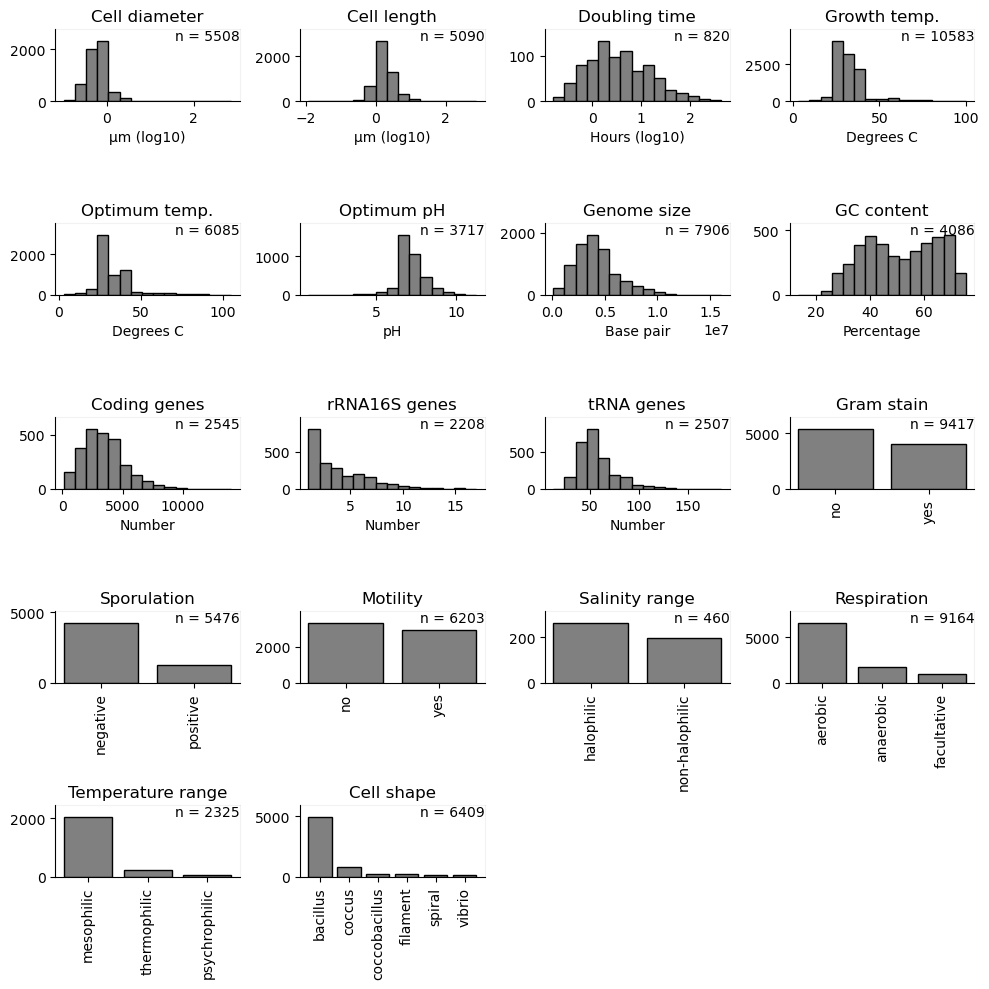

In [20]:
trait = pd.read_csv(trait_b2f_path, sep='\t')

titles = {'cell_diameter': 'Cell diameter', 'cell_length': 'Cell length', 'doubling_h': 'Doubling time', 'growth_tmp': 'Growth temp.', 'optimum_tmp': 'Optimum temp.', 'optimum_ph': 'Optimum pH', 'genome_size': 'Genome size', 'gc_content': 'GC content', 'coding_genes': 'Coding genes', 'rRNA16S_genes': 'rRNA16S genes', 'tRNA_genes': 'tRNA genes', 'gram_stain': 'Gram stain', 'sporulation': 'Sporulation', 'motility': 'Motility', 'range_salinity': 'Salinity range', 'respiration': 'Respiration', 'range_tmp': 'Temperature range', 'cell_shape': 'Cell shape'}

units = {'cell_diameter': 'µm (log10)', 'cell_length': 'µm (log10)', 'doubling_h': 'Hours (log10)', 'growth_tmp': 'Degrees C', 'optimum_tmp': 'Degrees C', 'optimum_ph': 'pH', 'genome_size': 'Base pair', 'gc_content': 'Percentage', 'coding_genes': 'Number', 'rRNA16S_genes': 'Number', 'tRNA_genes': 'Number'}

# Trait list
nt = ['cell_diameter', 'cell_length', 'doubling_h', 'growth_tmp', 'optimum_tmp', 'optimum_ph', 'genome_size', 'gc_content', 'coding_genes', 'rRNA16S_genes', 'tRNA_genes']
binary_ct = ['gram_stain', 'sporulation', 'motility', 'range_salinity']
multi_ct = ['respiration', 'range_tmp', 'cell_shape']

# Plot
ntraits = len(nt)+len(binary_ct)+len(multi_ct)
ncols = 4
nrows = math.ceil(float(ntraits) / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(2.5*ncols, 2*nrows))

# Continuous traits
for tr, ax in zip(nt, axes.flatten()):
    n, _, _ = ax.hist(trait[tr], bins=15, color='grey', edgecolor='black')
    ax.text(1, 1, f'n = {np.sum(~trait[tr].isnull())}',
            horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
    ax.set_title(titles[tr])
    ax.set_xlabel(units[tr])
    ax.set_ylim(0, n.max() * 1.2)
    # ax.tick_params(axis="x", labelrotation=90)
    ax.spines['top'].set(alpha=0.1, color='grey')
    ax.spines['right'].set(alpha=0.1, color='grey')

# Binary traits
for tr, ax in zip(binary_ct, axes.flatten()[len(nt):]):
    trait_values = trait[tr].dropna()
    if tr == 'gram_stain':
        trait_values = trait_values.replace(0, 'no').replace(1, 'yes')
    if tr == 'sporulation':
        trait_values = trait_values.replace(0, 'negative').replace(1, 'positive')
    if tr == 'motility':
        trait_values = trait_values.replace(0, 'no').replace(1, 'yes')
    if tr == 'range_salinity':
        trait_values = trait_values.replace(0, 'non-halophilic').replace(1, 'halophilic')
    cnt = Counter(trait_values)
    x = np.array(list(cnt.keys()))
    height = np.array(list(cnt.values()))
    sorted_index = np.argsort(height)[::-1]
    ax.bar(x=x[sorted_index], height=np.sort(height)[::-1], color='grey', edgecolor='black')
    ax.text(1, 1, f'n = {np.sum(~trait[tr].isnull())}',
            horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
    ax.set_title(titles[tr])
    ax.set_ylim(0, height.max() * 1.2)
    ax.tick_params(axis="x", labelrotation=90)
    # ax.set_xlabel(nt_units[tr])
    ax.spines['top'].set(alpha=0.1, color='grey')
    ax.spines['right'].set(alpha=0.1, color='grey')

# Multinomial traits
cnt_multi_ct = dict()
for mc in multi_ct:
    cnt = dict()
    for tr in trait.columns[16:]:
        if mc in tr:
            trait_values = trait[tr].dropna()
            trait_values = trait_values.replace(0, 'no').replace(1, tr)
            trait_category = tr.replace('_'+mc, '')
            cnt[trait_category] = Counter(trait_values)[tr]
    cnt_multi_ct[mc] = cnt

for tr, ax in zip(multi_ct, axes.flatten()[len(nt)+len(binary_ct):]):
    x = np.array(list(cnt_multi_ct[tr].keys()))
    height = np.array(list(cnt_multi_ct[tr].values()))
    sorted_index = np.argsort(height)[::-1]
    ax.bar(x=x[sorted_index], height=np.sort(height)[::-1], color='grey', edgecolor='black')
    ax.text(1, 1, f'n = {height.sum()}',
            horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
    ax.set_ylim(0, height.max() * 1.2)
    ax.set_title(titles[tr])
    ax.tick_params(axis="x", labelrotation=90)
    ax.spines['top'].set(alpha=0.1, color='grey')
    ax.spines['right'].set(alpha=0.1, color='grey')

for i in range(ntraits, nrows*ncols):
    axes.flatten()[i].set_visible(False)

plt.tight_layout()

# Save
plt.savefig("../../results/02_data_preprocessing/figS1.pdf", 
            format="pdf", dpi=300, facecolor="white", bbox_inches="tight", pad_inches=0.1)

## Prepare reference datasets for Bac2Feature

### Homology-based prediction

#### Extracting 16S rRNA seqs from SILVA SSU Ref NR99

In [ ]:
# Save the remaining node ID
acc_to_taxid = {madin_silva.loc[i, 'accession']: madin_silva.loc[i, 'species_tax_id'] for i in range(madin_silva.shape[0])}

# Extract full-length 16S rRNA sequences
silva_seq_path = os.path.join(silva_dir, 'SILVA_138.1_SSURef_NR99_tax_silva.fasta')
silva_seq_id_path = os.path.join(intermediate_dir, 'SILVA_138.1_SSURef_NR99_tax_silva_taxid.fasta')

records = list(SeqIO.parse(silva_seq_path, format='fasta'))
results_records = [r for r in records if r.id in acc_to_taxid]

for r in results_records:
    r.seq = r.seq.replace('.', '-')
    # Convert from RNA to DNA
    r.seq = r.seq.replace('U', 'T')
    # Convert from accession to taxid
    r.id = acc_to_taxid[r.id]
    r.description = ""

SeqIO.write(results_records, silva_seq_id_path, "fasta")

#### Constructing BLAST Database
```sh
makeblastdb -in ../../data/intermediate_dir/SILVA_138.1_SSURef_NR99_tax_silva_taxid.fasta -out ../../data/ref_bac2feature/homology/blastdb -dbtype nucl
```

### Taxonomy-based prediction

#### Calculating empirical distributions of reference trait data

In [37]:
# Make reference dataset for taxonomy-based prediction

# Trait table
trait = pd.read_csv(trait_b2f_path, sep="\t", dtype=str)
# SILVA taxonomy
silva_taxonomy = pd.read_csv(taxonomy_path, sep="\t", dtype=str)
silva_taxonomy.fillna("", inplace=True)

def concat_taxonomy(silva_metadata):
    taxonomy = ("k__" + silva_metadata["superkingdom"] +
                "; p__" + silva_metadata["phylum"] +
                "; c__" + silva_metadata["class"] +
                "; o__" + silva_metadata["order"] +
                "; f__" + silva_metadata["family"] +
                "; g__" + silva_metadata["genus"] +
                "; s__" + silva_metadata["species"])
    return taxonomy

silva_taxonomy["taxonomy"] = silva_taxonomy.apply(lambda df: concat_taxonomy(df), axis=1)
# Save
silva_taxonomy[["species_tax_id", "taxonomy"]].to_csv(os.path.join(out_dir, 'intermediate_dir', 'qiime_taxonomy.tsv'), sep='\t', index=False)

# Merge
tax_cols = ['taxonomy', 'superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
ref_trait = pd.merge(trait, silva_taxonomy[["species_tax_id"]+tax_cols], how="inner", on="species_tax_id")

nt = ['cell_diameter', 'cell_length', 'doubling_h', 'growth_tmp', 'optimum_tmp', 'optimum_ph', 'genome_size', 'gc_content', 'coding_genes', 'rRNA16S_genes', 'tRNA_genes']

ct = ['gram_stain',
      'sporulation', 'motility', 'range_salinity', 'facultative_respiration',
      'anaerobic_respiration', 'aerobic_respiration', 'mesophilic_range_tmp',
      'thermophilic_range_tmp', 'psychrophilic_range_tmp',
      'bacillus_cell_shape', 'coccus_cell_shape', 'filament_cell_shape',
      'coccobacillus_cell_shape', 'vibrio_cell_shape', 'spiral_cell_shape']

clades = ["superkingdom", "phylum", "class",
          "order", "family", "genus", "species"]
prefix = ["k__", "p__", "c__", "o__", "f__", "g__", "s__"]

# Calculate empirical distributions of reference traits
emp_trait = {}
for t in nt+ct:
    emp = {}
    ref_trait[t] = ref_trait[t].astype(float)
    for c in clades:
        cols = [c, t]
        groupby = ref_trait[cols].groupby(c).mean()
        groupby = groupby.reset_index()
        groupby.fillna({t: "NA"}, inplace=True)
        emp[c] = {groupby.loc[i, c]: groupby.loc[i, t]
                    for i in range(groupby.shape[0])}
    emp_trait[t] = emp
# Save
emp_file = open(f'../../data/ref_bac2feature/taxonomy/empirical_dictribution.json', mode='w')
json.dump(emp_trait, emp_file, ensure_ascii=False)
emp_file.close()

#### Training naive-bayes classifier

```sh
# Activate Conda environment
conda activate qiime2-2023.5
# Import
qiime tools import --type 'FeatureData[Taxonomy]' --input-format HeaderlessTSVTaxonomyFormat --input-path ../../data/intermediate_dir/qiime_taxonomy.tsv --output-path ../../data/intermediate_dir/qiime_taxonomy.qza
qiime tools import --type 'FeatureData[Sequence]' --input-path ../../data/intermediate_dir/SILVA_138.1_SSURef_NR99_tax_silva_taxid.fasta --output-path ../../data/intermediate_dir/ref_seq_full.qza
# Train naive-bayes classifier
qiime feature-classifier fit-classifier-naive-bayes --i-reference-reads ../../data/intermediate_dir/ref_seq_full.qza --i-reference-taxonomy ../../data/intermediate_dir/qiime_taxonomy.tsv --o-classifier ../../data/ref_bac2feature/taxonomy/nb_classifier.qza
```

### Phylogeny-based prediction
```sh
conda activate bac2feature_experiment
```

#### Pruning the phylogenetic tree of SILVA SSU Ref NR99

In [ ]:
# Path
silva_large_tree_w_single_quote_path = os.path.join(silva_dir, 'SILVA_138.1_SSURef_NR99.accessions.ntree')
silva_large_tree_path = os.path.join(intermediate_dir, 'silva_large_tree.tre')
index_list_path = os.path.join(intermediate_dir, 'remained_nodeid_index.txt')
silva_pruned_tree_path = os.path.join(intermediate_dir, 'silva_pruned_tree.tre')
silva_pruned_taxid_tree_path = os.path.join(intermediate_dir, 'silva_pruned_taxid_tree.tre')

# Remove single quotation to avoid an read error
tree = Phylo.read(silva_large_tree_w_single_quote_path, format='newick')
leaves = tree.get_terminals()
sys.setrecursionlimit(10000)
Phylo.write(tree, silva_large_tree_path, 'newick')

# Save the remaining node ID
acc_to_taxid = {madin_silva.loc[i, 'accession']: madin_silva.loc[i, 'species_tax_id'] for i in range(madin_silva.shape[0])}

remained_nodeid = [l for l in leaves if l.name in acc_to_taxid]
with open(index_list_path, 'w') as f:
    f.writelines([str(id) + '\n' for id in remained_nodeid])

# Pruning the phylogenetic tree
command = ['Rscript',
           'prune_tree.R',
           '-i',
           silva_large_tree_path,
           '-o',
           silva_pruned_tree_path,
           '-k',
           index_list_path]
process = subprocess.run(command)

# Preprocess the pruned tree
pruned_tree = Phylo.read(silva_pruned_tree_path, format='newick')
# To input into RAxML, the node labels must be removed.
for t in pruned_tree.get_nonterminals():
    t.name = ''
# Convert accession to NCBI taxid
for t in pruned_tree.get_terminals():
    t.name = acc_to_taxid[t.name]

# Save
Phylo.write(pruned_tree, silva_pruned_taxid_tree_path, 'newick')
# subprocess.run(['cp', silva_pruned_taxid_tree_path, os.path.join(silva_dir, 'tree.nwk')])

#### Extracting 16S rRNA seqs from SILVA MSA

In [ ]:
# Extract MSA of 16S rRNA sequences
silva_seq_path = os.path.join(silva_dir, 'SILVA_138.1_SSURef_NR99_tax_silva_full_align_trunc.fasta')
silva_seq_id_path = os.path.join(intermediate_dir, 'SILVA_138.1_SSURef_NR99_tax_silva_full_align_trunc_taxid.fasta')

records = list(SeqIO.parse(silva_seq_path, format='fasta'))
results_records = [r for r in records if r.id in acc_to_taxid]

for r in results_records:
    r.seq = r.seq.replace('.', '-')
    # Convert from RNA to DNA
    r.seq = r.seq.replace('U', 'T')
    # Convert from accession to taxid
    r.id = acc_to_taxid[r.id]
    r.description = ""

SeqIO.write(results_records, silva_seq_id_path, "fasta")

#### Trim MSA of 16S rRNA gene sequences with trimal
```sh
trimal -gt 0.10 -in ../../data/intermediate_dir/SILVA_138.1_SSURef_NR99_tax_silva_full_align_trunc_taxid.fasta -out ../../data/intermediate_dir/silva_msa_trim.fasta
```

#### Construct of the reference dataset for PICRUSt2's pipeline
```sh
# MSA
cp ../../data/intermediate_dir/silva_msa_trim.fasta ../../data/ref_bac2feature/phylogeny/phylogeny.fasta
# HMM profile
hmmbuild ../../data/ref_bac2feature/phylogeny/phylogeny.hmm ../../data/ref_bac2feature/phylogeny/phylogeny.fasta
# Parameter estimation by Raxml-ng
raxml-ng --evaluate --msa ../../data/ref_bac2feature/phylogeny/phylogeny.fasta --tree ../../data/intermediate_dir/silva_pruned_taxid_tree.tre --prefix ../../data/intermediate_dir/phylogeny --model GTR+G+F --blmin 0.0001 -blmax 1.5
# Rerooting tree optimized by Raxml-ng (root ad midpoint)
Rscript rerooting.R
# Copy tree and model
cp ../../data/intermediate_dir/phylogeny.raxml.bestTree.rerooted ../../data/ref_bac2feature/phylogeny/phylogeny.tre
cp ../../data/intermediate_dir/phylogeny.raxml.bestModel ../../data/ref_bac2feature/phylogeny/phylogeny.model
```